# Bonus-Track Assignment 2: Sequential MNIST classification task
Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [24]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
import keras_tuner as kt
from keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import pandas as pd

# [Load final Results]

In [25]:
#manually trained hyperparameter (number of epochs)
best_epoch = np.load('best_epoch_rnn.npy')

print(f'Number of epochs: {best_epoch}')
#best model
hypermodel = keras.models.load_model('keras_model_rnn')

#history variable
history = pd.read_json('history.json')

#errors 
accuracy = np.load('accuracy.npy')
print(f'\nTraining Accuracy = {accuracy[0]} \nTest Accuracy = {accuracy[1]}')

FileNotFoundError: [Errno 2] No such file or directory: 'best_epoch_rnn.npy'

## Load the dataset

In [27]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()


print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


Plot the first digits

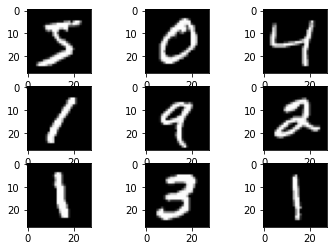

[5 0 4 1 9 2 1 3 1 4]


In [28]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

print(train_y[:10])

In [29]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoder.fit(test_y)

encoded__train_Y = encoder.transform(train_y)
encoded__test_Y = encoder.transform(test_y)

# convert integers to one hot encoded
y_train = np_utils.to_categorical(encoded__train_Y)
y_test = np_utils.to_categorical(encoded__test_Y)


flatten the input images into vectors

784


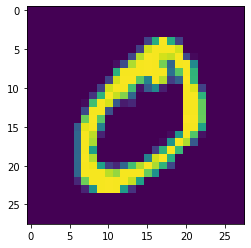

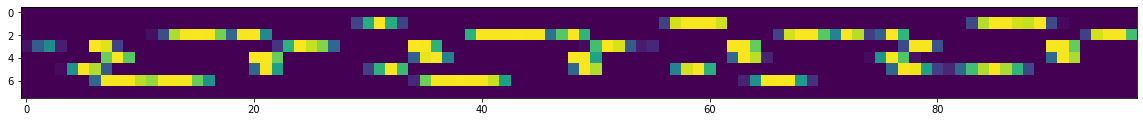

In [30]:
x_train = train_X.reshape(train_X.shape[0], -1)
x_test = test_X.reshape(test_X.shape[0], -1)
print(x_train.shape[1])

n = 1
x = train_X[n]
plt.imshow(x)
plt.show()
plt.figure(figsize = (20,15))
xx = (x_train[n]).reshape(8, int(len(x_train[n])/8))
plt.imshow(xx)




In [31]:
#reshape the data to feed the RNN
X_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
Y_train = np.reshape(y_train, (y_train.shape[0],1,y_train.shape[1]))
Y_train = y_train
X_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
Y_test = np.reshape(y_test, (y_test.shape[0],1,y_test.shape[1]))
Y_test = y_test
#check the shapes
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(60000, 784, 1)
(60000, 10)
(10000, 784, 1)
(10000, 10)


### Create the model
To do model selection, we actually create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [32]:
bs = 500 #batch size

In [33]:
def model_architecture(lr, hidden_units, activation_h):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation_h, input_shape=(bs,784,1), stateful = True, batch_input_shape=(bs,784,1))) 
    model.add(Dense(units=10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
    return model

def create_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 50-120
    hidden_units = hp.Int('units',  min_value=50, max_value=120, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # call model-building code with the hyperparameter values.
    model = model_architecture( hidden_units = hidden_units, activation_h = activation_h, lr=lr
    )
    return model

Instantiate hyperparameter tuner

In [34]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel=create_model,
                     objective='val_accuracy',
                     max_trials=20,
                     #overwrite=True,
                     directory='tuner',
                     project_name='tuner_rnn'
                     )

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from tuner/tuner_rnn/tuner0.json


INFO:tensorflow:Reloading Tuner from tuner/tuner_rnn/tuner0.json


Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [35]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Train the model

In [36]:
tuner.search(X_train, Y_train, epochs=20, batch_size = bs, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
""")


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Completed hyperparameters search.

Otimal number of units of hidden layer = 70 

Optimal learning rate for the optimizer = 0.0001 

Optimal activation function for the hidden layer = tanh 




Find the optimal number of epochs

In [37]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(X_train, Y_train, epochs=250, batch_size = bs, verbose=2, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (500, 70)                 5040      
                                                                 
 dense_2 (Dense)             (500, 10)                 710       
                                                                 
Total params: 5,750
Trainable params: 5,750
Non-trainable params: 0
_________________________________________________________________


2023-06-03 08:07:49.480488: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


Epoch 1/250
96/96 - 39s - loss: 2.1069 - accuracy: 0.2461 - val_loss: 1.9379 - val_accuracy: 0.3158 - 39s/epoch - 401ms/step
Epoch 2/250
96/96 - 39s - loss: 1.8763 - accuracy: 0.3219 - val_loss: 1.8088 - val_accuracy: 0.3222 - 39s/epoch - 405ms/step
Epoch 3/250
96/96 - 41s - loss: 1.7969 - accuracy: 0.3369 - val_loss: 1.7548 - val_accuracy: 0.3517 - 41s/epoch - 423ms/step
Epoch 4/250
96/96 - 41s - loss: 1.7604 - accuracy: 0.3527 - val_loss: 1.7312 - val_accuracy: 0.3508 - 41s/epoch - 424ms/step
Epoch 5/250
96/96 - 40s - loss: 1.7389 - accuracy: 0.3610 - val_loss: 1.7110 - val_accuracy: 0.3713 - 40s/epoch - 420ms/step
Epoch 6/250
96/96 - 40s - loss: 1.7248 - accuracy: 0.3651 - val_loss: 1.6995 - val_accuracy: 0.3720 - 40s/epoch - 421ms/step
Epoch 7/250
96/96 - 41s - loss: 1.7161 - accuracy: 0.3702 - val_loss: 1.6953 - val_accuracy: 0.3660 - 41s/epoch - 422ms/step
Epoch 8/250
96/96 - 40s - loss: 1.7122 - accuracy: 0.3701 - val_loss: 1.6891 - val_accuracy: 0.3733 - 40s/epoch - 416ms/step


Find best epoch:

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
np.save('best_epoch_rnn',best_epoch)

AttributeError: 'dict' object has no attribute 'history'

Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

In [ ]:
# Retrain the model
history = hypermodel.fit(X_train, Y_train,batch_size = bs, epochs=best_epoch, verbose=2, validation_split = 0.2).history

Epoch 1/100


2023-06-02 21:30:25.086478: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


96/96 - 38s - loss: 2.1891 - accuracy: 0.1996 - val_loss: 2.0989 - val_accuracy: 0.2306 - 38s/epoch - 393ms/step
Epoch 2/100
96/96 - 36s - loss: 2.0673 - accuracy: 0.2224 - val_loss: 2.0302 - val_accuracy: 0.2299 - 36s/epoch - 379ms/step
Epoch 3/100
96/96 - 36s - loss: 2.0347 - accuracy: 0.2323 - val_loss: 2.0101 - val_accuracy: 0.2373 - 36s/epoch - 375ms/step
Epoch 4/100
96/96 - 36s - loss: 2.0223 - accuracy: 0.2330 - val_loss: 2.0013 - val_accuracy: 0.2498 - 36s/epoch - 372ms/step
Epoch 5/100
96/96 - 36s - loss: 2.0186 - accuracy: 0.2389 - val_loss: 2.0040 - val_accuracy: 0.2547 - 36s/epoch - 374ms/step
Epoch 6/100
96/96 - 36s - loss: 2.0143 - accuracy: 0.2533 - val_loss: 1.9887 - val_accuracy: 0.2707 - 36s/epoch - 374ms/step
Epoch 7/100
96/96 - 36s - loss: 2.0072 - accuracy: 0.2646 - val_loss: 1.9863 - val_accuracy: 0.2708 - 36s/epoch - 372ms/step
Epoch 8/100
96/96 - 36s - loss: 1.9980 - accuracy: 0.2660 - val_loss: 1.9738 - val_accuracy: 0.2698 - 36s/epoch - 373ms/step
Epoch 9/100


Save history data

In [ ]:
hist_df = pd.DataFrame(history) 
# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

To load the history data use:

In [ ]:
#history = pd.read_json('history.json')

### Make plots of the loss and validation loss

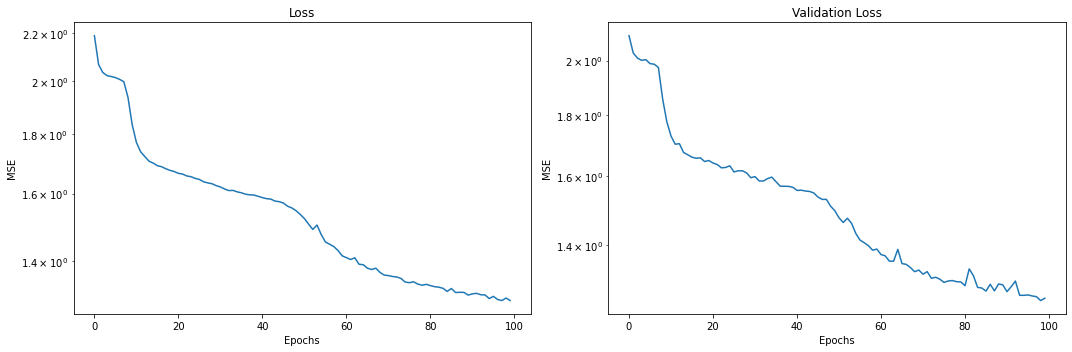

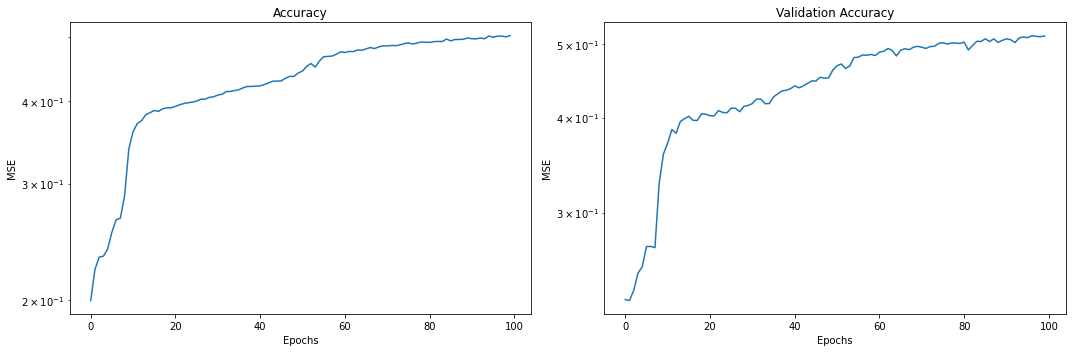

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Loss')
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/RNN_loss.pdf")


plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Accuracy')
plt.plot(history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Accuracy')
plt.plot(history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/RNN_loss.pdf")

plt.show()

Save the model

In [ ]:
hypermodel.save('keras_model_rnn')

INFO:tensorflow:Assets written to: keras_model_rnn/assets


INFO:tensorflow:Assets written to: keras_model_rnn/assets


Command to (eventually) load the saved model:

In [ ]:
#hypermodel = keras.models.load_model('keras_model_rnn')

### Evaluate the model

In [ ]:
#scores = model.evaluate(X_train, Y_train,batch_size = bs, verbose=0,validation_split = 0.2)
#print("Training Accuracy: %.2f%%" % (scores[1]*100))
accuracy = []

scores = model.evaluate(X_test, Y_test,batch_size = bs, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

#scores = hypermodel.evaluate(X_train, Y_train,batch_size = bs, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))
#accuracy.append(scores[1])


scores = hypermodel.evaluate(X_test, Y_test,batch_size = bs, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
accuracy.append(scores[1])

#np.save('accuracy',accuracy)

Accuracy: 51.68%
Accuracy: 50.16%
